## <center>Run all</center>

### Step1:加载库与函数

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'
import sys
sys.path.append('/home/chenjn/rna2adt')

%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from tqdm import tqdm
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import fowlkes_mallows_score as FMI
from sklearn.metrics import silhouette_score as SC
from scipy.stats import pearsonr, spearmanr
import dataset
import dataloaders
import scanpy as sc
import scbasset_ori as scbasset
import sklearn
from biock import make_directory, make_logger, get_run_info
from biock.pytorch import model_summary, set_seed
from biock import HG19_FASTA_H5, HG38_FASTA_H5

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs/All/epoch_20")

from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import issparse

from utils import find_res_label
from scipy.spatial.distance import cosine

In [3]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    assert y_pred.size == y_true.size
    
    encoder = LabelEncoder()
    encoder = encoder.fit(np.unique(y_true))
    y_true = encoder.transform(y_true).astype(np.int64)
    y_pred = y_pred.astype(np.int64)

    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)

    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    # ind = linear_assignment(w.max() - w)
    ind = linear_sum_assignment(w.max() - w)
    ind = np.array((ind[0], ind[1])).T

    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size


def label_scores(embeddings, labels):
    n_neigh = min(20, len(embeddings) // 3)
    nn_ = NearestNeighbors(n_neighbors=n_neigh)
    nn_.fit(embeddings)
    knns = nn_.kneighbors(embeddings, return_distance=False)

    res = 0
    for i in range(len(embeddings)):
        num = 0
        for j in range(len(knns[i])):
            if labels[i] == labels[knns[i][j]]:
                num += 1
        res += num / len(knns[i])

    return res / len(embeddings)


def get_CSS(data1, data2, dim=1,  func=cosine):
    r1, p1 = [], []
    # print(data1.shape, data2.shape)
    for g in range(data1.shape[dim]):
        if dim == 1:
            # print(np.sum(data1[:, g]), np.sum(data2[:, g]))
            r = func(data1[:, g], data2[:, g])
        elif dim == 0:
            # print(np.sum(data1[g, :]), np.sum(data2[g, :]))
            r = func(data1[g, :], data2[g, :])
        # print(r)
        r1.append(r)
    r1 = np.array(r1)
    return np.mean(r1)


def get_R(data1, data2, dim=1, func=pearsonr):
    r1, p1 = [], []
    # print(data1.shape, data2.shape)
    for g in range(data1.shape[dim]):
        if dim == 1:
            # print(np.isnan(data1[:, g]).any())
            # print(np.isnan(data2[:, g]).any())
            # print(np.isinf(data1[:, g]).any())
            # print(np.isinf(data2[:, g]).any())
            # print(np.sum(data1[:, g]), np.sum(data2[:, g]))
            r, pv = func(data1[:, g], data2[:, g])
        elif dim == 0:
            # print(np.isnan(data1[g, :]).any())
            # print(np.isnan(data2[g, :]).any())
            # print(np.isinf(data1[g, :]).any())
            # print(np.isinf(data2[g, :]).any())
            # print(np.sum(data1[g, :]), np.sum(data2[g, :]))
            r, pv = func(data1[g, :], data2[g, :])
        # print(r)
        r1.append(r)
        p1.append(pv)
    r1 = np.array(r1)
    p1 = np.array(p1)

    return r1, p1


def test_model(model, loader, device, epoch):
    model.eval()
    all_label = list()
    all_pred = list()

    for it, (seq, adt) in enumerate(tqdm(loader)):
        seq = seq.to(device)
        output = model(seq)[0].detach()
        output = torch.sigmoid(output).cpu().numpy().astype(np.float16)

        adt = adt.numpy().astype(np.float16)

        all_pred.append(output)
        all_label.append(adt)

    all_pred = np.concatenate(all_pred, axis=0)
    all_label = np.concatenate(all_label, axis=0)

    R = get_R(all_pred, all_label, dim=0)[0]
    R1 = get_R(all_pred, all_label, dim=1)[0]
    print("T2",all_pred.shape,all_label.shape)

    css = get_CSS(all_pred, all_label, dim=0)
    css1 = get_CSS(all_pred, all_label, dim=1)


    def mseloss(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        mse = np.mean((y_true - y_pred) ** 2)
        return mse
    All_Loss = mseloss(all_pred, all_label)

    R = np.nanmean(R)
    R1 = np.nanmean(R1)

    embedding = model.get_embedding().detach().cpu().numpy().astype(np.float32)

    adata1 = sc.AnnData(
        embedding,
        obs=adtT.obs,
    )
    # print(adata1)
    sc.pp.neighbors(adata1, use_rep='X')
    sc.tl.umap(adata1)

    sc.tl.louvain(adata1)
    # adata1.obs['louvain_res'] = find_res_label(adata1, len(np.unique(adata1.obs[label_key])))

    if label_key is not None:
        ari = ARI(adata1.obs['louvain'], adata1.obs[label_key])
        nmi = NMI(adata1.obs['louvain'], adata1.obs[label_key])
        ca = cluster_acc(adata1.obs[label_key].to_numpy(), adata1.obs['louvain'].values.to_numpy())
        fmi = FMI(adata1.obs['louvain'], adata1.obs[label_key])
        sci = SC(adata1.X, adata1.obs['louvain'].values.reshape(-1, 1))
        lsi = label_scores(embedding, adata1.obs[label_key])
    else:
        ari = 0.
        nmi = 0.
        ca = 0.
        fmi = 0.
        sci = SC(adata1.X, adata1.obs['louvain'].values.reshape(-1, 1))
        lsi = 0.

    # ari_res = ARI(adata1.obs['louvain_res'], adata1.obs[label_key])
    # nmi_res = NMI(adata1.obs['louvain_res'], adata1.obs[label_key])
    # ca_res = cluster_acc(adata1.obs[label_key].to_numpy(), adata1.obs['louvain_res'].values.to_numpy())
    # fmi_res = FMI(adata1.obs['louvain_res'], adata1.obs[label_key])
    # sci_res = SC(adata1.X, adata1.obs['louvain_res'].values.reshape(-1, 1))
    sci_res = None

    if epoch is not None:
        print('ARI: ' + str(ari) + ', NMI: ' + str(nmi) + ', CA: ' + str(ca) + ', FMI: ', str(fmi))
        print('SCI: ' + str(sci) + ', LSI: ' + str(lsi) + ', css: ', str(css) + ', css1: ', str(css1) + ', All_loss', All_Loss)
        # print('ARI: ' + str(ari_res) + ', NMI: ' + str(nmi_res) + ', CA: ' + str(ca_res) + ', FMI', str(fmi_res) + ', SCI', str(sci_res))

        writer.add_scalar('ARI', ari, global_step=epoch)
        writer.add_scalar('NMI', nmi, global_step=epoch)
        writer.add_scalar('CA', ca, global_step=epoch)
        writer.add_scalar('FMI', fmi, global_step=epoch)
        writer.add_scalar('SC', sci, global_step=epoch)
        writer.add_scalar('PCC0', R, global_step=epoch)
        writer.add_scalar('PCC1', R1, global_step=epoch)
        writer.add_scalar('lsi', lsi, global_step=epoch)
        writer.add_scalar('css', css, global_step=epoch)
        writer.add_scalar('css1', css1, global_step=epoch)
        writer.add_scalar('All_Loss', All_Loss, global_step=epoch)

    return R, R1, sci, sci_res, embedding


def split_dataset(length, tr, va):
    seq = np.random.permutation(np.arange(length))
    trs = seq[:int(length * tr)]
    vas = seq[int(length * tr) : int(length * (tr + va))]
    tes = seq[int(length * (tr + va)):]

    return trs, vas, tes


def plot_ump(adata,label_key,clust_way="louvain"):
    sc.pl.umap(adata, color=label_key)
    sc.pl.umap(adata, color='louvain')

def clusters_val(adata,label_key,clust_way="louvain"):
    print("="*100)
    print("="*100)
    print("="*10,clust_way,"="*10)
    print("ARI:",ARI(adata.obs[clust_way], adata.obs[label_key]))
    print("NMI",NMI(adata.obs[clust_way], adata.obs[label_key]))
    print("CA:",cluster_acc(adata.obs[label_key].to_numpy(), adata.obs[clust_way].values.to_numpy()))
    print("FNI:",FMI(adata.obs[clust_way], adata.obs[label_key]))
    print()
 
 
    if issparse(adata.X):
        dense_X = adata.X.toarray()
    else:
        dense_X = adata.X
    print("Label_Score:",label_scores(dense_X,adata.obs[label_key]))
    print("SC",SC(adata.X, adata.obs['louvain']))
    print()


### Step2:超参数设置

In [4]:
seq_len = 1344
batch_size = 4
num_workers = 1
z_dim = 256 
lr = 0.01
max_epoch = 20
batch = None # ['P1', 'P2']
seed = 3407
# seed = 0

In [5]:
set_seed(seed, force_deterministic=True)
outdir = make_directory('./output')
device = torch.device("cuda:7") if torch.cuda.is_available() else torch.device("cpu")

### Step3:设置数据

In [6]:
def run(data_name,adtT,batch_size,num_workers,lr=1e-3,max_epoch=100,label_key=None):
    train_loader = DataLoader(
        adtT,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        prefetch_factor=4
    )

    model = scbasset.scBasset(n_cells=adtT.X.shape[1], hidden_size=z_dim, seq_len=seq_len, batch_ids=adtT.batche_ids).to(device)

    load = False
    if not load:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        criterion = nn.MSELoss()
        scaler = GradScaler()

        best_sci = 0
        best_embedding = None

        max_epoch = max_epoch
        for epoch in range(max_epoch):
            pool = [np.nan for _ in range(10)]
            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epoch}")
            epoch_loss = 0;num_batches=0
            model.train()
            for it, (seq, adt) in enumerate(pbar):
                seq, adt = seq.to(device), adt.to(device)

                optimizer.zero_grad()
                with autocast():
                    output = model(seq)[0]
                    # print(output[0], adt[0])
                    loss = criterion(output, adt)
                    # print(loss)

                epoch_loss += loss.item()
                num_batches += 1
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                pool[it % 10] = loss.item()

                lr = optimizer.param_groups[-1]["lr"]
                pbar.set_postfix_str(f"loss/lr={np.nanmean(pool):.4f}/{lr:.3e}")
            
            avg_loss = epoch_loss / num_batches
            writer.add_scalar('Loss/train', avg_loss, epoch)
            
            if epoch % 1 == 0: 
                pcc0, pcc1, sci, sci_res, embedding = test_model(model, train_loader, device, epoch)
                
                if sci > best_sci:
                    best_sci = sci
                    best_epoch = epoch
                    best_embedding = embedding


    embedding = best_embedding
    adata1 = sc.AnnData(
        embedding,
        obs=adtT.obs,
    )
    sc.pp.neighbors(adata1, use_rep='X')
    sc.tl.louvain(adata1)
    # sc.tl.louvain(adata1, random_state=seed)6
    # adata1.obs['louvain_res'] = find_res_label(adata1, len(np.unique(adata1.obs[label_key])))
    adata1.write(f"/home/chenjn/rna2adt/A_run_test/new_emb_sc/{data_name}.h5ad")

    clusters_val(adata1,label_key,clust_way="louvain")
    print(f"Best epoch{best_epoch}")
    print("="*60)

    sc.tl.umap(adata1)
    plot_ump(adata1,label_key,clust_way="louvain")


### Step4:Run(reap2 训练数据 early_stop机制)

============================== P0:karen2018a_16 ==============================
Cell:8212    ADT:36
------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 36.06it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.24383839646023234, NMI: 0.29633335591349047, CA: 0.45470043838285434, FMI:  0.4112688233100602
SCI: 0.043324713, LSI: 0.5902277155382397, css:  1.0049617555406358, css1:  0.9224375071057562, All_loss 2.076


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 43.68it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.2866419726563135, NMI: 0.3879486797051746, CA: 0.4640769605455431, FMI:  0.42117651637872816
SCI: 0.043513034, LSI: 0.7133889430102258, css:  0.9628655115763346, css1:  0.8788642269036158, All_loss 2.104


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 46.17it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.35802379160570197, NMI: 0.46681475525303545, CA: 0.5007306380905991, FMI:  0.48070971104141574
SCI: 0.050089832, LSI: 0.7485813443740792, css:  0.9927185906304253, css1:  0.9273924567367876, All_loss 2.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 41.19it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.36597053326337925, NMI: 0.47862916361530594, CA: 0.5393326838772527, FMI:  0.487664114058742
SCI: 0.05407953, LSI: 0.7622138334145078, css:  0.9639388190375434, css1:  0.8378832968295753, All_loss 1.814


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 42.27it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.3767295268332521, NMI: 0.5007160579152091, CA: 0.5521188504627375, FMI:  0.49842481774189085
SCI: 0.05281403, LSI: 0.7729785679493326, css:  0.9738030831019083, css1:  0.859602980094309, All_loss 1.824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.24it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.4096354902624847, NMI: 0.5048931001585646, CA: 0.5764734534827083, FMI:  0.5262397803831651
SCI: 0.062367935, LSI: 0.7751948368241504, css:  0.9949825074937608, css1:  0.8957331764497701, All_loss 1.909


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 39.52it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.3989713229258686, NMI: 0.5134193055804721, CA: 0.5785435947394058, FMI:  0.5169865025060328
SCI: 0.06268208, LSI: 0.7808938139308249, css:  0.9955672158135308, css1:  0.9029125444594674, All_loss 1.899


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 44.40it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.3731415151595208, NMI: 0.5138817379837568, CA: 0.5627131027764247, FMI:  0.49486156144103643
SCI: 0.061114002, LSI: 0.7820445689235163, css:  0.9921371142069498, css1:  0.8816302577010957, All_loss 1.874


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 41.94it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.42516946499791564, NMI: 0.5322226418091751, CA: 0.5864588407208963, FMI:  0.541003569575813
SCI: 0.06606329, LSI: 0.7868667803214702, css:  0.9849063886536492, css1:  0.9055070075112555, All_loss 1.917


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 42.89it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.41350534190509675, NMI: 0.5125919951124371, CA: 0.5935216755966878, FMI:  0.5288842274464615
SCI: 0.06751833, LSI: 0.7854968339015965, css:  0.9922252231174045, css1:  0.8876626660010318, All_loss 1.885


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 46.56it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.42267654969518437, NMI: 0.5153179416242337, CA: 0.6030199707744763, FMI:  0.5386520822445598
SCI: 0.060455427, LSI: 0.7885107160253182, css:  1.0044835408528645, css1:  0.8791891705740155, All_loss 1.95


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 40.84it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.41272127698463107, NMI: 0.5179609722400002, CA: 0.5884072089624939, FMI:  0.5301131422123416
SCI: 0.06256039, LSI: 0.790611300535792, css:  0.984230465359158, css1:  0.8997064573890804, All_loss 1.887


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 40.43it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.5033408639362073, NMI: 0.5424172761826795, CA: 0.6910618606916707, FMI:  0.6055172727502907
SCI: 0.07274308, LSI: 0.794434973209929, css:  0.9886666271421645, css1:  0.8705118554601191, All_loss 1.861


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 47.32it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.38104564396693164, NMI: 0.5176735098262012, CA: 0.576595226497808, FMI:  0.5036055376043469
SCI: 0.06695192, LSI: 0.7986726741354029, css:  0.9968839751349555, css1:  0.8850553703711663, All_loss 1.883


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 47.02it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.4360557721427258, NMI: 0.5245499889577959, CA: 0.6404042864101315, FMI:  0.5493546217888733
SCI: 0.07440439, LSI: 0.7975340964442211, css:  0.9895801544189453, css1:  0.8804400087027101, All_loss 1.871


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 46.14it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.44147763666450085, NMI: 0.5378373943131913, CA: 0.6440574768631271, FMI:  0.5548457280220194
SCI: 0.07508326, LSI: 0.797801997077438, css:  0.9952287210358514, css1:  0.892137049859289, All_loss 1.876


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 41.94it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.4021475671216838, NMI: 0.516554751082453, CA: 0.60837798343887, FMI:  0.5212773895897176
SCI: 0.07639386, LSI: 0.7986848514369113, css:  0.989418453640408, css1:  0.8740002576586565, All_loss 1.857


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 44.24it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.40058917952019013, NMI: 0.5065612533167962, CA: 0.5977837311251827, FMI:  0.5196280374046214
SCI: 0.07330411, LSI: 0.8005114466634076, css:  0.9949608908759223, css1:  0.8888814813383487, All_loss 1.876


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 45.91it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.4495351275354791, NMI: 0.5324554569435941, CA: 0.6529469069654165, FMI:  0.5615999517866379
SCI: 0.08288176, LSI: 0.8044020944958479, css:  0.9879169464111328, css1:  0.9024934175751352, All_loss 1.896


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 43.71it/s]


T2 (36, 8212) (36, 8212)
ARI: 0.4620010493205684, NMI: 0.5424336789754164, CA: 0.6643935703848027, FMI:  0.571689103169912
SCI: 0.08695098, LSI: 0.8044568923526454, css:  0.9970070521036783, css1:  0.888724559343738, All_loss 1.874
========== louvain ==========
ARI: 0.4620010493205684
NMI 0.5424336789754164
CA: 0.6643935703848027
FNI: 0.571689103169912

Label_Score: 0.8044568923526454
SC 0.08695098

Best epoch19


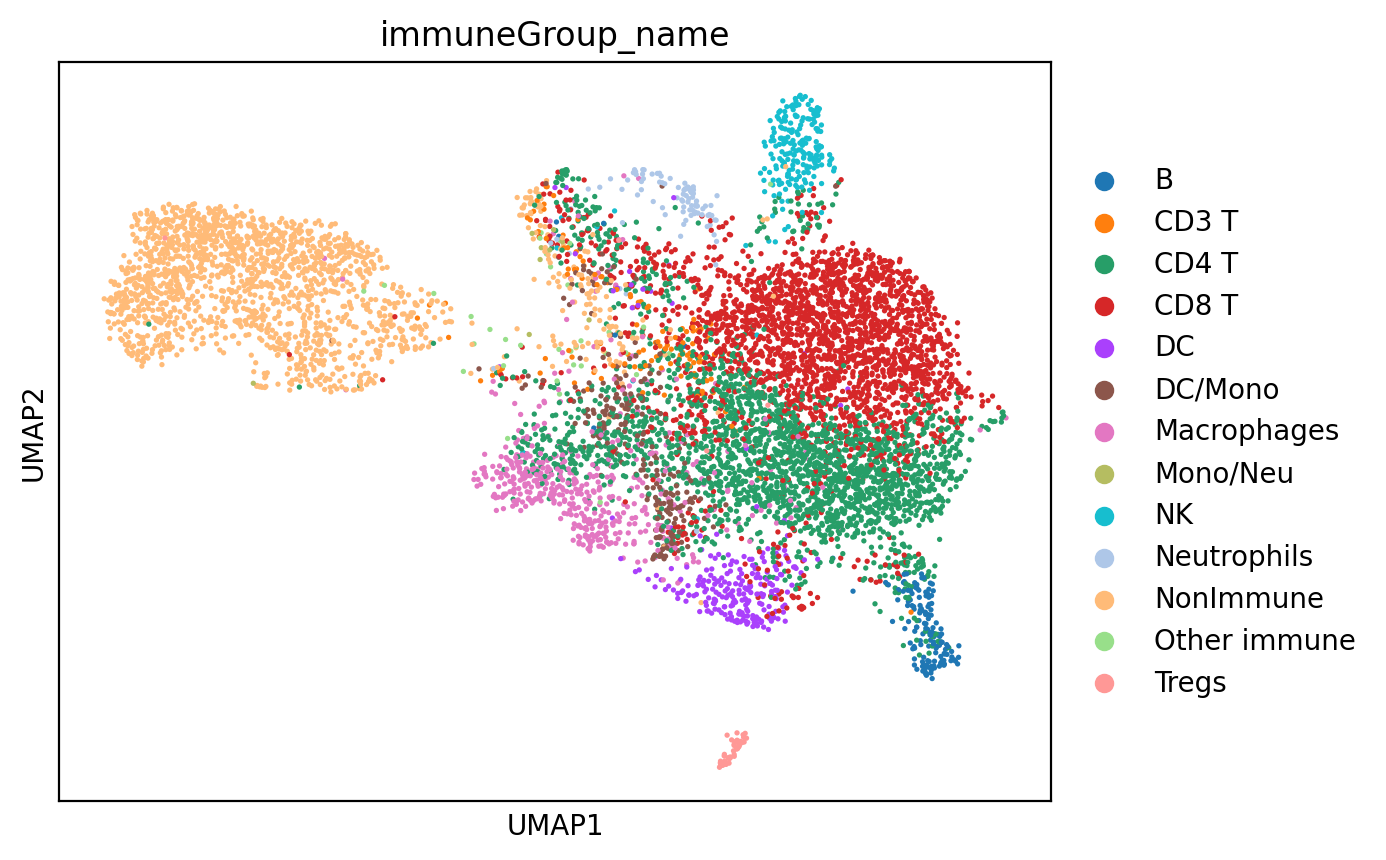

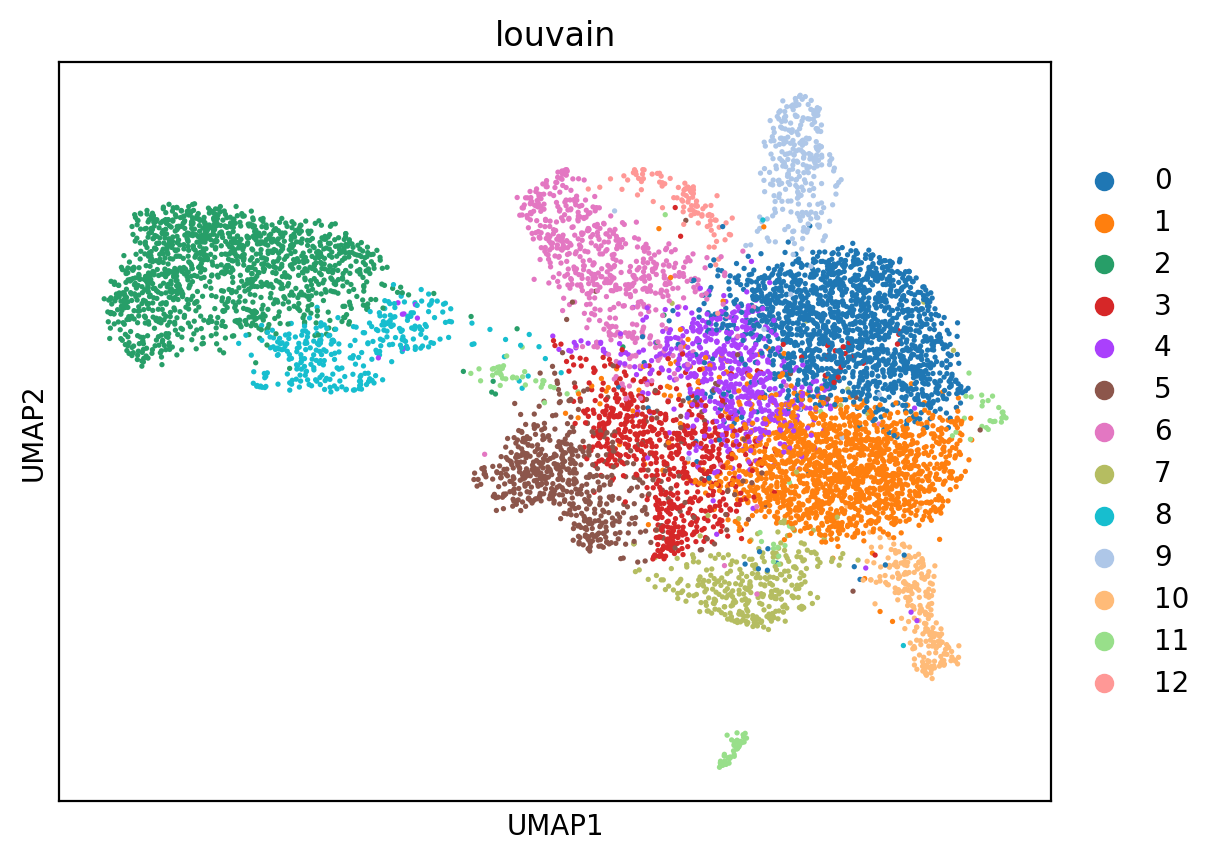

In [7]:
data_names = ["karen2018a_16"] 
label_keys = ['immuneGroup_name']

for i in range(len(data_names)):
    data = data_names[i]
    label_key = label_keys[i]
    adt_data = '/home/chenjn/rna2adt/data/' + data + '/ADT.h5ad'
    ref_data = '/home/chenjn/rna2adt/data/pbmc/CCND.csv'

    tem_data = sc.read_h5ad(adt_data)

    print("="*30,f"P{i}:{data}","="*30)
    print(f"Cell:{tem_data.shape[0]}    ADT:{tem_data.shape[1]}")
    # print(tem_data)
    print("-"*60)

    
    adtT = dataset.SingleCellDataset(
        data=dataset.load_adata(adt_data, hvg=False, log1p=False, nor=False), 
        seq_ref=dataset.load_csv(ref_data),
        seq_len=seq_len, 
        batch=batch,
    )

    run(data,adtT,batch_size,num_workers,lr=lr,max_epoch=max_epoch,label_key=label_key)

writer.close()